In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)
from stock_utils import *

In [5]:
def RSI(series, period):
    
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.DataFrame.ewm(u, com=period-1, adjust=False).mean() / \
         pd.DataFrame.ewm(d, com=period-1, adjust=False).mean()
    
    return 100 - 100 / (1 + rs)


def rsi_class(x):
    ret = "low"
    if x < 50:
        ret = "low"
    if x > 50:
        ret = "med"
    if x > 70:
        ret = "high"
    return(ret)

In [6]:
from datetime import datetime
tech_list = ['AAPL', 'GOOG', 'AMZN']

start = "2010-01-01"
end = datetime.now()
for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    
company_list = [AAPL, GOOG, AMZN]
company_name = ["APPLE", "GOOGLE", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600,APPLE
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800,APPLE
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000,APPLE
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200,APPLE
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453413,447610800,APPLE
2010-01-11,7.600000,7.607143,7.444643,7.503929,6.396483,462229600,APPLE
2010-01-12,7.471071,7.491786,7.372143,7.418571,6.323723,594459600,APPLE
2010-01-13,7.423929,7.533214,7.289286,7.523214,6.412923,605892000,APPLE
2010-01-14,7.503929,7.516429,7.465000,7.479643,6.375782,432894000,APPLE


In [141]:
n_lookback = 500
n_forecast = 30
df_stock = AAPL.reset_index().copy()

In [142]:
df_stock, df_left = create_backtest_frames(df_stock,n_lookback,n_forecast)

In [143]:
df_stock = feature_creation(df_stock)

In [144]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3262 non-null   datetime64[ns]
 1   Open          3262 non-null   float64       
 2   High          3262 non-null   float64       
 3   Low           3262 non-null   float64       
 4   Close         3262 non-null   float64       
 5   Adj Close     3262 non-null   float64       
 6   Volume        3262 non-null   int64         
 7   company_name  3262 non-null   object        
 8   50D-SMA       3213 non-null   float64       
 9   50D-EMA       3262 non-null   float64       
 10  rsi           3248 non-null   float64       
 11  rsicat        3262 non-null   int8          
 12  average       3262 non-null   float64       
 13  vwap          3262 non-null   float64       
 14  vwap_pct_ret  3261 non-null   float64       
 15  pvwap         3261 non-null   float64 

In [145]:
df_stock.bfill(inplace=True)
df_stock.ffill(inplace=True)

In [146]:
#df_left = df_stock.iloc[:-100]
df_stock.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,company_name,50D-SMA,50D-EMA,rsi,rsicat,average,vwap,vwap_pct_ret,pvwap
3257,2022-12-09,142.339996,145.570007,140.899994,142.160004,142.160004,76097000,APPLE,145.151999,146.969722,44.366149,1,142.876668,142.160004,-0.003435,0.016390
3258,2022-12-12,142.699997,144.500000,141.059998,144.490005,144.490005,70462700,APPLE,145.277799,146.872478,48.145280,1,143.350001,144.490005,0.016390,0.006782
3259,2022-12-13,149.500000,149.970001,144.240005,145.470001,145.470001,93886200,APPLE,145.338199,146.817479,49.693143,1,146.560003,145.470001,0.006782,-0.015536
3260,2022-12-14,145.350006,146.660004,141.160004,143.210007,143.210007,82291200,APPLE,145.280399,146.676010,46.263487,1,143.676671,143.210007,-0.015536,-0.046854
3261,2022-12-15,141.110001,141.800003,136.029999,136.500000,136.500000,98931900,APPLE,145.082400,146.276950,37.899904,1,138.110001,136.500000,-0.046854,-0.046854


In [147]:
df_left.head()

,Date,Open,High,Low,Close,Adj Close,Volume,company_name
3262,2022-12-16,136.690002,137.649994,133.729996,134.509995,134.509995,160156900,APPLE
3263,2022-12-19,135.110001,135.199997,131.320007,132.369995,132.369995,79592600,APPLE
3264,2022-12-20,131.389999,133.250000,129.889999,132.300003,132.300003,77432800,APPLE
3265,2022-12-21,132.979996,136.809998,132.750000,135.449997,135.449997,85928000,APPLE
3266,2022-12-22,134.350006,134.559998,130.300003,132.229996,132.229996,77852100,APPLE


In [148]:
# Removing last n rows
#df_dropped_last_n = df.iloc[:-100]
 

In [149]:
df_stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'company_name', '50D-SMA', '50D-EMA', 'rsi', 'rsicat', 'average',
       'vwap', 'vwap_pct_ret', 'pvwap'],
      dtype='object')

In [150]:
features = ['Close','50D-EMA','rsi','rsicat','pvwap']
x = df_stock[features]
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x)

In [151]:
y = df_stock['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

In [152]:
f_len = len(features)

In [157]:
%run stock_utils.py
a,b = create_train_test_windows(x,y,n_lookback,n_forecast)
stock_model = create_model(n_lookback,n_forecast,f_len,model_type='BiLSTM')
stock_model.fit(a, b, epochs=2, batch_size=32)


Epoch 1/2
86/86 [==============================] - 202s 2s/step - loss: 0.0239
Epoch 2/2
86/86 [==============================] - 206s 2s/step - loss: 0.0014


In [158]:
#stock_model = tf.keras.models.load_model('saved_models/AAPL_7day_model')

In [161]:
%run stock_utils.py
df_f,df_p = make_future_dataframe(df_stock,x,y,n_lookback,n_forecast,stock_model,scaler,features,f_len)

In [125]:
df_p.tail()

,Date,Actual,50D-SMA,50D-EMA,rsi,rsicat,Forecast
3227,2022-10-27,144.800003,152.168399,149.506928,46.811996,1,NaN
3228,2022-10-28,155.740005,151.800200,149.751363,59.543661,2,NaN
3229,2022-10-31,153.339996,151.436599,149.892093,56.356558,2,NaN
3230,2022-11-01,150.649994,151.098199,149.921815,52.936449,2,NaN
3231,2022-11-02,145.029999,150.654199,149.729979,46.576802,1,145.029999


In [41]:
df_.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,company_name
3286,2023-01-24,96.930000,98.089996,96.000000,96.320000,96.320000,66929500,AMAZON
3287,2023-01-25,92.559998,97.239998,91.519997,97.180000,97.180000,94261600,AMAZON
3288,2023-01-26,98.239998,99.489998,96.919998,99.220001,99.220001,68523600,AMAZON
3289,2023-01-27,99.529999,103.489998,99.529999,102.239998,102.239998,87678100,AMAZON
3290,2023-01-30,101.089996,101.739998,99.010002,101.250000,101.250000,46040604,AMAZON


In [42]:
df_f['Date'] = pd.bdate_range(dummy,periods=n_forecast)

In [47]:
from datetime import timedelta

print(dummy+timedelta(days=1))

2023-01-31 20:09:59.673267


In [ ]:
import matplotlib.pyplot as plt
df_left['Forecast'] = df_f['Forecast']
df_left.plot(x='Date',y=['Forecast','Close'])

In [162]:
rmse = np.sqrt(np.mean(((np.array(df_f['Forecast'])- np.array(df_left['Close'])) ** 2)))
rmse

12.984221618824414

In [163]:
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
print(mean_absolute_percentage_error(np.array(df_left['Close']), np.array(df_f['Forecast'])))
print(mean_absolute_error(np.array(df_left['Close']), np.array(df_f['Forecast'])))

0.07424501751581289
9.850588734944662


In [ ]:
stock_model.save('saved_models/AAPL_30day_Bi_model')
#stock_model = tf.keras.models.load_model('saved_models/AMZN_60day_Bi_model')

INFO:tensorflow:Assets written to: saved_models/AAPL_30day_Bi_model\assets


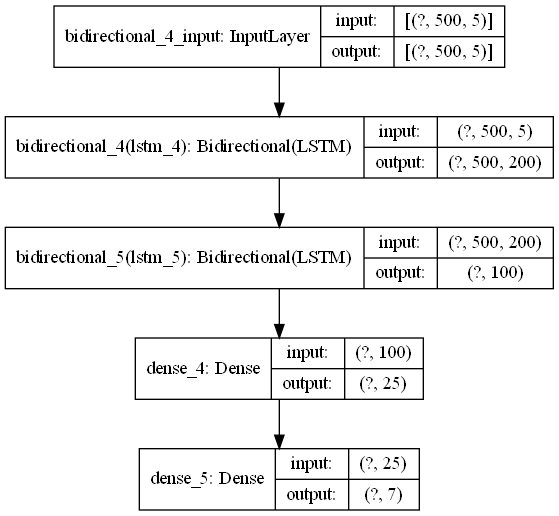

In [90]:
ifile = 'model_archs/AMZN_60day_model.png'
tf.keras.utils.plot_model(stock_model, to_file = ifile, show_shapes = True, show_layer_names = True)

In [19]:
dummy = datetime.now()

In [20]:
dummy

datetime.datetime(2023, 1, 30, 20, 9, 59, 673267)

In [21]:
business_days = pd.bdate_range(dummy,periods=7)

In [132]:
df_f.shape

(60, 3)

In [138]:
from datetime import datetime, timedelta
today = datetime.now()
next_day = today+timedelta(days=1)
df_f['Date'] = pd.bdate_range(next_day,periods=n_forecast)

In [139]:
today

datetime.datetime(2023, 1, 31, 21, 33, 28, 730407)

In [140]:
next_day

datetime.datetime(2023, 2, 1, 21, 33, 28, 730407)

In [137]:
df_f.head()

,Date,Actual,Forecast
0,2023-04-03,NaN,141.756714
1,2023-04-04,NaN,154.282227
2,2023-04-05,NaN,147.149353
3,2023-04-06,NaN,152.861603
4,2023-04-07,NaN,158.435730


In [ ]:
#df_Actual = df.loc[(df['Date']>='2022-08-23')&(df['Date']<='2022-10-11')]

In [ ]:
#df_Actual.head(36)

In [ ]:
#new_df = pd.merge(df_Actual, df_future,  how='inner',on='Date')

In [ ]:
#new_df.head(36)

In [ ]:
#df_future = df_future[df_future.Date.dt.weekday < 5]

In [ ]:
#from sklearn.metrics import mean_squared_error
#mean_squared_error(np.array(new_df['Close']),np.array(new_df['Forecast']))
#df_future.head(5)

In [ ]:
#df_Actual.shape

In [ ]:
#rmse = np.sqrt(np.mean(((np.array(df_future['Forecast'])- np.array(df_Actual['Close'])) ** 2)))
#rmse

In [ ]:
#results = df_past.append(df_future).set_index('Date')

# plot the results
#results.plot(title='AAPL')